### Obtenición de ángulos en flechas sobre el pavimento

Utilizar una red YOLO-OBB no nos sirve porque no obtendríamos la orientación, sino el rectángulo rotado que mejor encaja con el objeto.

La propuesta para obtener la orientación de las flechas consiste en diseñar una CNN ad-hoc que entrenaremos con las imágenes de las flechas extraidas por YOLO y la rotación proporcionada en los labels.

Para ello se eliminarán todas las imágenes que no tienen flechas, y de las que sí tienen se recortará cada flecha (puede haber varias y se reescalará a unas dimensiones fijas (por determinar), añadiendo el ángulo reportado en los labels.

Con ese dataset se entrenará una red tipo VGG para obtener dada una imagen de una flecha el ángulo que forma.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

def load_samples (directory, size=None):
    data = pd.read_csv(directory, sep='\t', header=None) 
    print(data)
    
    X = []
    Y = []
    for i in range(len(data)):
        print('.', end='')
        # carga la imagen
        imgname = data.iloc[i,0]
        img = cv2.imread(imgname)
        if size != None:
            img = cv2.resize(img, size)
        X.append(img)
        Y.append(data.iloc[i,1])

    return (np.array(X), np.array(Y))

In [7]:
X, Y = load_samples("./dataset_cleaned.csv",(64,64)) # for model that require higher than 64x64 resolution

                                                   0         1
0        dataset/lyrs=y&x=498928&y=388383&z=20-0.png  0.747256
1        dataset/lyrs=y&x=498933&y=388386&z=20-1.png  0.085187
2        dataset/lyrs=y&x=498934&y=388391&z=20-2.png  0.634782
3        dataset/lyrs=y&x=498934&y=388391&z=20-3.png  0.140102
4        dataset/lyrs=y&x=498940&y=388395&z=20-4.png  0.887765
...                                              ...       ...
6696  dataset/lyrs=y&x=530663&y=391686&z=20-7116.png  0.514914
6697  dataset/lyrs=y&x=530669&y=391622&z=20-7117.png  0.385349
6698  dataset/lyrs=y&x=530672&y=391647&z=20-7118.png  0.652626
6699  dataset/lyrs=y&x=530676&y=391636&z=20-7119.png  0.598877
6700  dataset/lyrs=y&x=530680&y=391631&z=20-7120.png  0.615035

[6701 rows x 2 columns]
...........................................................................................................................................................................................................................

In [9]:
print(X.shape)
print(Y.shape)

# get train and test sets
import sklearn.model_selection

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.10, random_state=42) # this random_state is similar to the bootstrap results

(6701, 64, 64, 3)
(6701,)


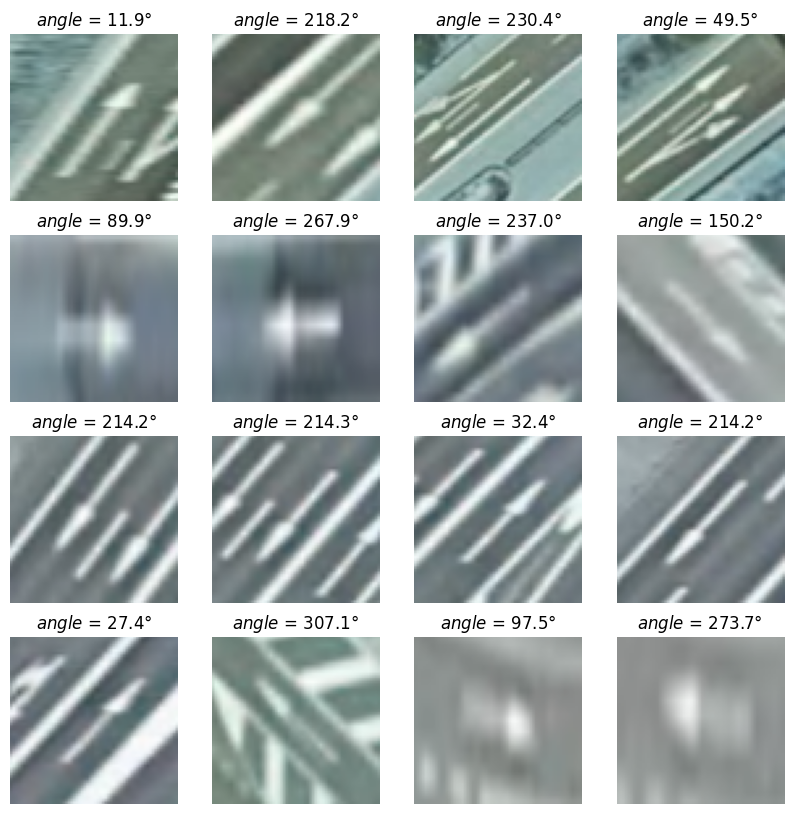

In [10]:
# imprime algunos ejemplos

N = 16

fig, axs = plt.subplots(N//4,4,figsize=(10, 10*N//16))
axs = axs.flatten()
plt.axis('off')

im0 = 567
for i in range(N):
    axs[i].axis('off')
    axs[i].imshow(X[im0+i])
    #axs[i].title.set_text(f"$angle$ = {(Y[im0+i]):.3f}")
    axs[i].title.set_text(f"$angle$ = {(360*Y[im0+i]):.1f}°")

#plt.savefig("test.png", bbox_inches='tight')

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import metrics


# create a Sequential model
model = Sequential()

# add convolutional layers with ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.5))
# flatten output of last pooling layer
model.add(Flatten())
# add fully connected layer with ReLU activation function

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='linear'))

# compile model with mean absolute error loss function and adam optimizer
model.compile(loss='mean_absolute_error', optimizer="adam", metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError()])



In [9]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
170/170 [==============================] - 29s 163ms/step - loss: 1.5688 - mean_absolute_error: 1.5688 - mean_squared_error: 191.0914 - val_loss: 0.2314 - val_mean_absolute_error: 0.2314 - val_mean_squared_error: 0.0713
Epoch 2/100
170/170 [==============================] - 25s 149ms/step - loss: 0.2221 - mean_absolute_error: 0.2221 - mean_squared_error: 0.0732 - val_loss: 0.1783 - val_mean_absolute_error: 0.1783 - val_mean_squared_error: 0.0568
Epoch 3/100
170/170 [==============================] - 25s 147ms/step - loss: 0.1943 - mean_absolute_error: 0.1943 - mean_squared_error: 0.0624 - val_loss: 0.1974 - val_mean_absolute_error: 0.1974 - val_mean_squared_error: 0.0607
Epoch 4/100
170/170 [==============================] - 25s 145ms/step - loss: 0.1847 - mean_absolute_error: 0.1847 - mean_squared_error: 0.0587 - val_loss: 0.1459 - val_mean_absolute_error: 0.1459 - val_mean_squared_error: 0.0435
Epoch 5/100
170/170 [==============================] - 25s 148ms/step - loss: 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 256)       2

In [44]:
model.load_weights("./models/14-03-23-18:37.h5")

21/21 [==============================] - 1s 24ms/step
Y = 314.537, Yp = 320.958, error = 6.420
Y = 213.992, Yp = 208.571, error = 5.421
Y = 123.520, Yp = 136.901, error = 13.380
Y = 211.887, Yp = 214.152, error = 2.265
Y = 226.759, Yp = 227.691, error = 0.932
Y = 158.384, Yp = 153.014, error = 5.370
Y = 284.389, Yp = 277.868, error = 6.521
Y = 268.261, Yp = 271.765, error = 3.504
Y = 219.478, Yp = 229.080, error = 9.603
Y = 19.624, Yp = 17.642, error = 1.983
Y = 310.188, Yp = 309.526, error = 0.662
Y = 148.406, Yp = 136.404, error = 12.002
Y = 237.740, Yp = 247.079, error = 9.339
Y = 240.642, Yp = 238.564, error = 2.078
Y = 85.882, Yp = 63.554, error = 22.328
Y = 73.203, Yp = 70.721, error = 2.481
Y = 252.790, Yp = 248.179, error = 4.611
Y = 226.143, Yp = 217.488, error = 8.654
Y = 124.029, Yp = 128.272, error = 4.242
Y = 190.644, Yp = 202.054, error = 11.410
Y = 272.643, Yp = 271.748, error = 0.895
Y = 85.113, Yp = 76.027, error = 9.086
Y = 212.056, Yp = 212.187, error = 0.130
Y = 291

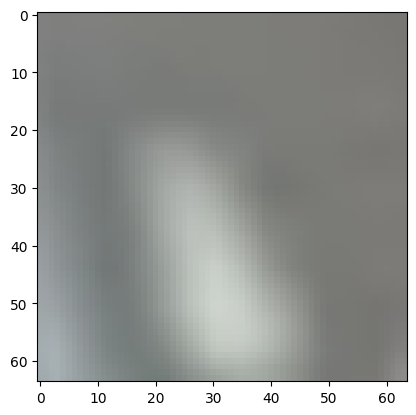

Y = 278.666, Yp = 229.219, error = 49.447


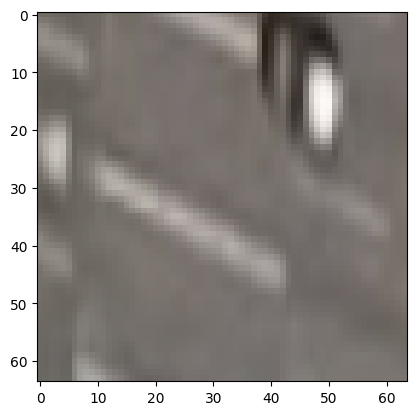

Y = 218.375, Yp = 173.968, error = 44.407


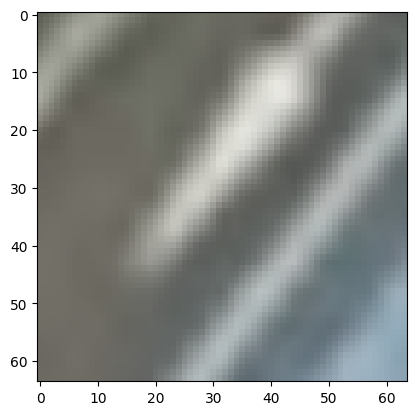

Y = 116.605, Yp = 189.968, error = 73.362


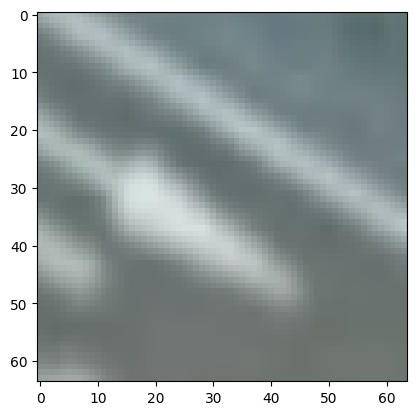

Y = 184.386, Yp = 7.079, error = 177.307


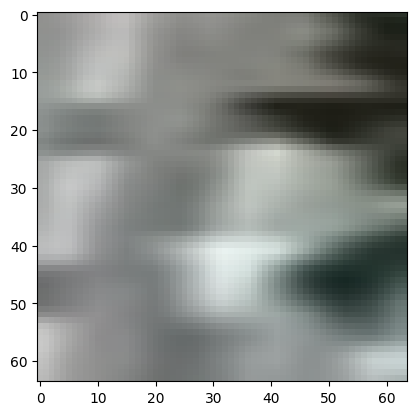

Y = 26.881, Yp = 52.318, error = 25.436


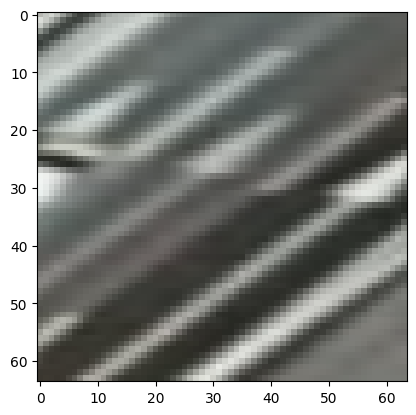

Y = 266.009, Yp = 233.509, error = 32.501


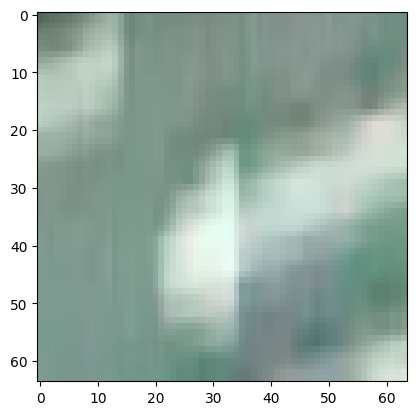

Y = 176.728, Yp = 216.994, error = 40.266


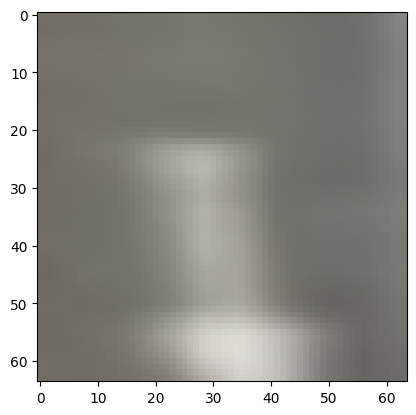

Y = 357.368, Yp = 256.335, error = 101.032


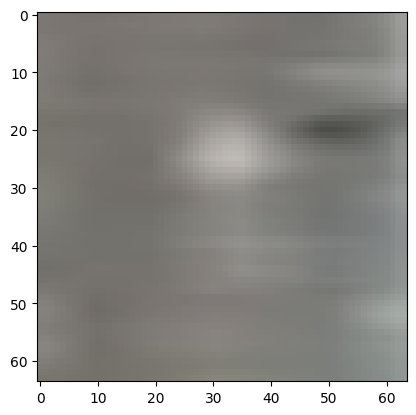

Y = 240.192, Yp = 44.976, error = 195.217


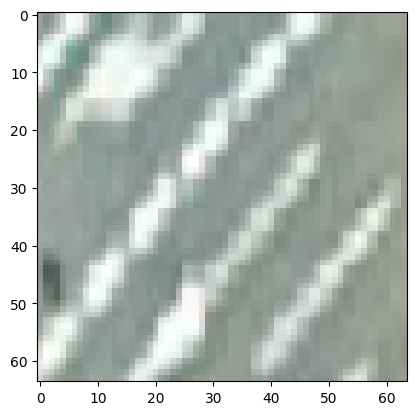

Y = 358.798, Yp = 18.332, error = 340.466


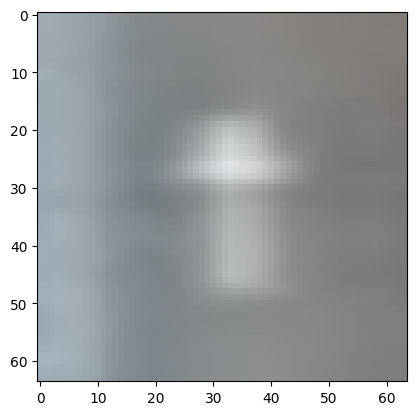

Y = 0.063, Yp = 336.594, error = 336.531


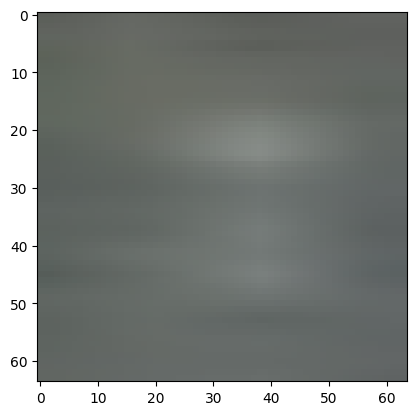

Y = 336.306, Yp = 260.882, error = 75.423


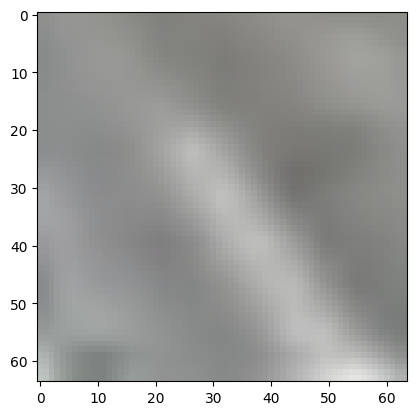

Y = 254.507, Yp = 208.040, error = 46.468


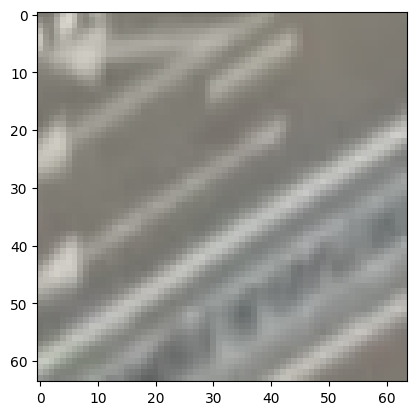

Y = 178.756, Yp = 211.742, error = 32.986


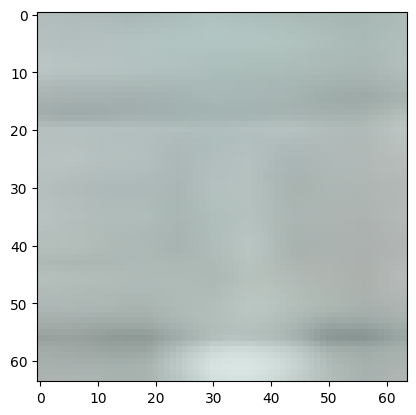

Y = 244.173, Yp = 210.858, error = 33.316


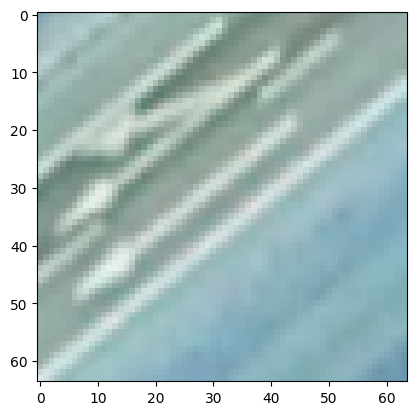

Y = 195.709, Yp = 92.719, error = 102.990


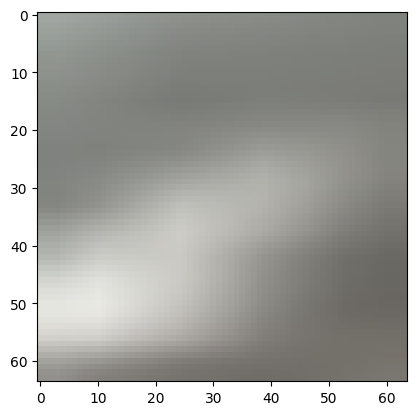

Y = 318.177, Yp = 276.903, error = 41.274


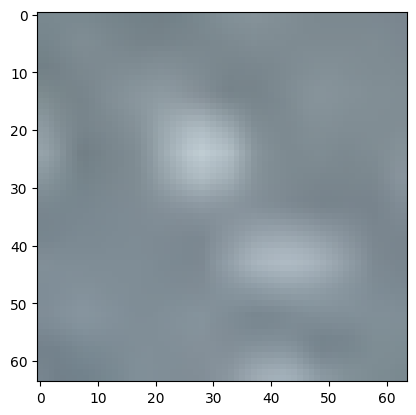

Y = 358.995, Yp = 1.073, error = 357.922


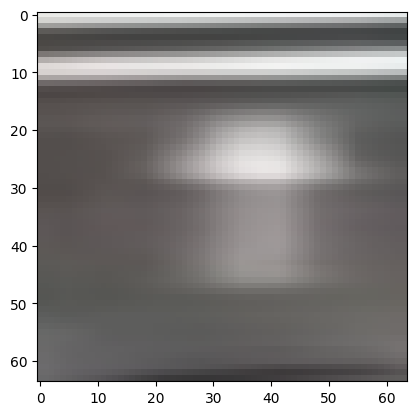

Y = 349.580, Yp = 231.638, error = 117.942


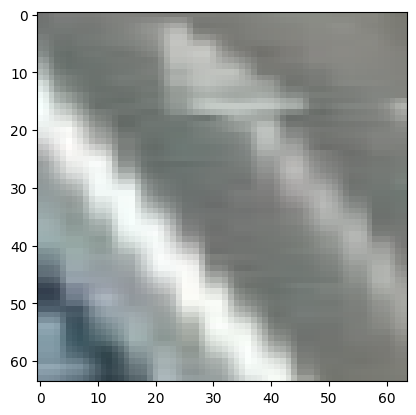

Y = 31.551, Yp = 4.017, error = 27.534


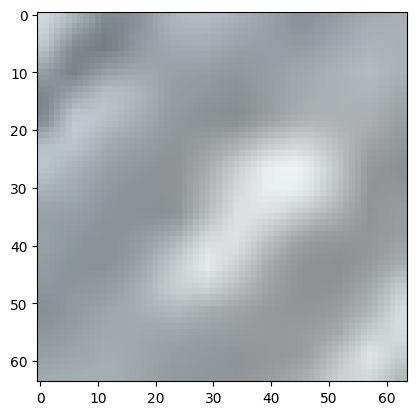

Y = 2.233, Yp = 316.713, error = 314.481


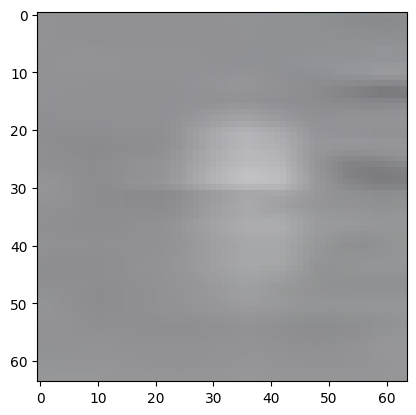

Y = 106.140, Yp = 233.856, error = 127.716


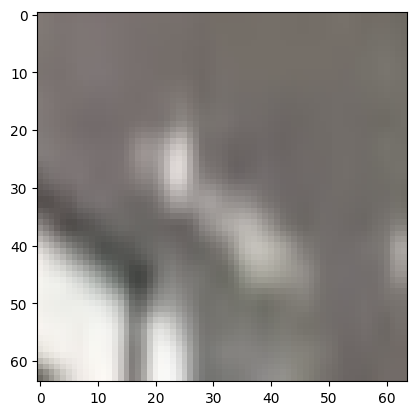

Y = 265.012, Yp = 159.447, error = 105.564


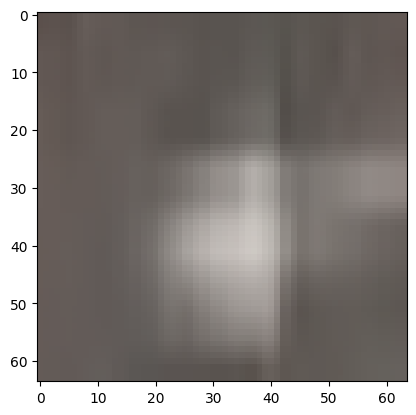

Y = 90.583, Yp = 149.327, error = 58.745


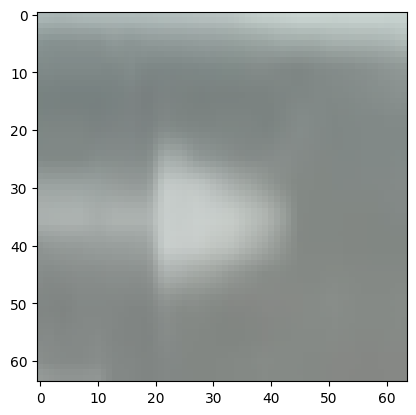

Y = 27.390, Yp = 175.178, error = 147.788


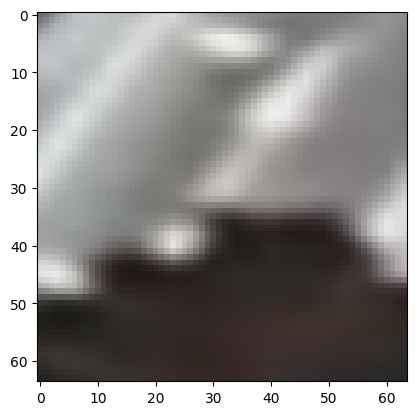

Y = 358.365, Yp = 144.760, error = 213.605


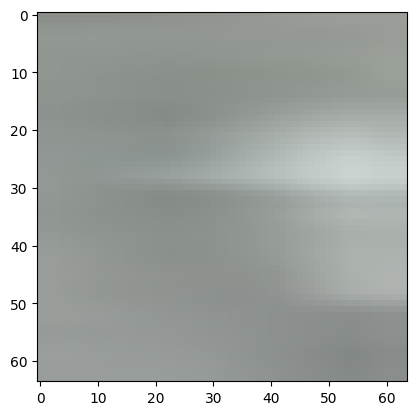

Y = 186.390, Yp = -0.495, error = 186.885


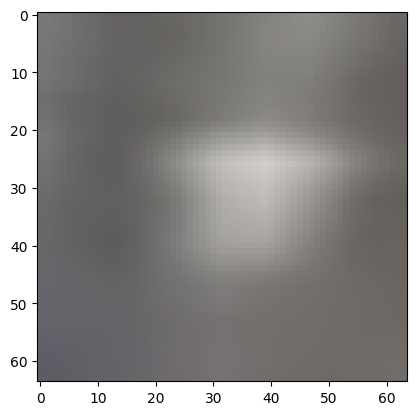

Y = 106.235, Yp = 137.165, error = 30.930


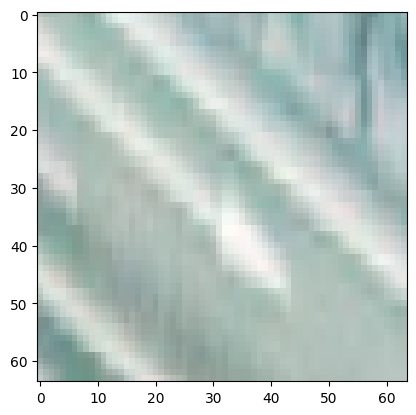

Y = 117.808, Yp = 298.174, error = 180.367


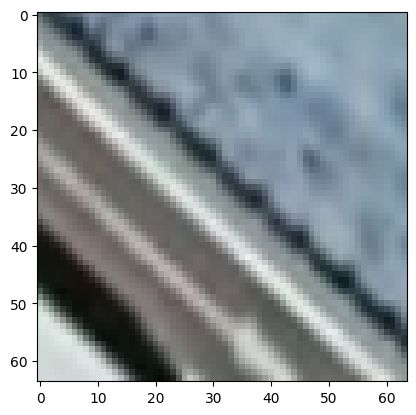

Y = 343.751, Yp = 300.330, error = 43.420


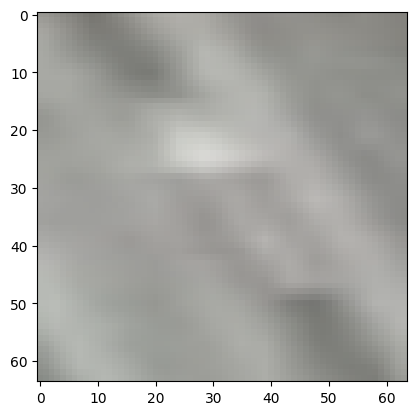

Y = 359.161, Yp = 239.333, error = 119.828


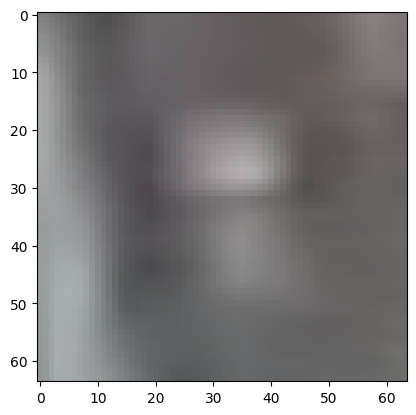

Y = 359.642, Yp = 1.030, error = 358.612


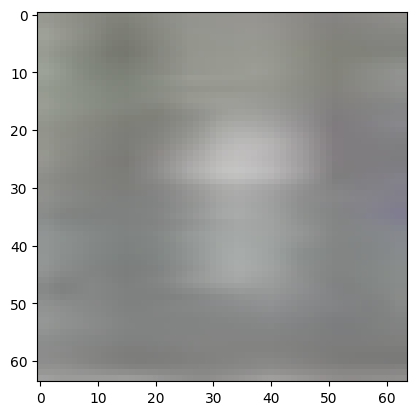

Y = 29.511, Yp = 226.679, error = 197.168


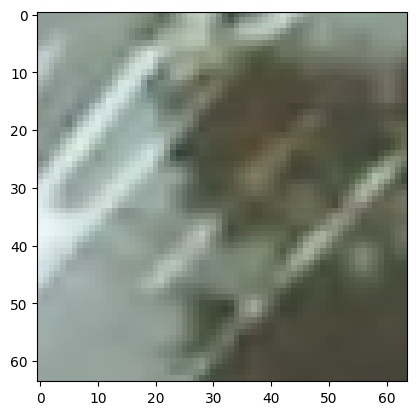

Y = 72.651, Yp = 111.542, error = 38.891


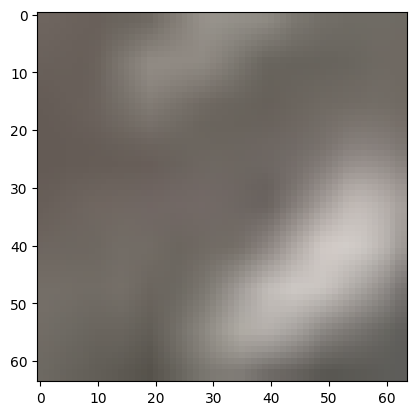

Y = 232.855, Yp = 199.201, error = 33.654


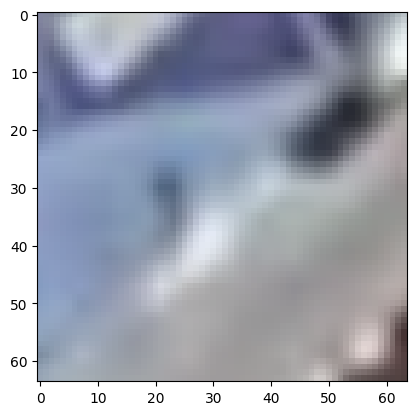

Y = 52.039, Yp = 88.127, error = 36.088


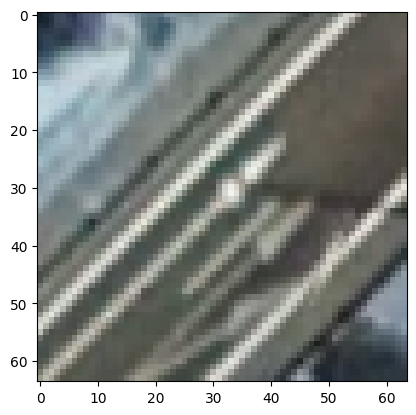

Y = 285.729, Yp = 170.485, error = 115.244


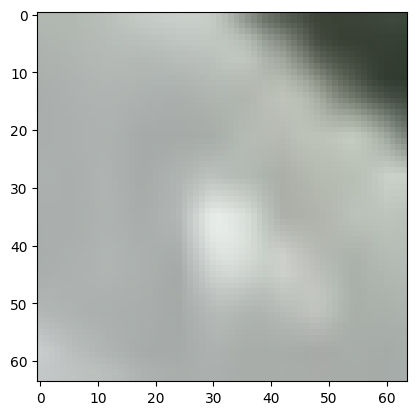

Y = 151.326, Yp = 218.573, error = 67.247


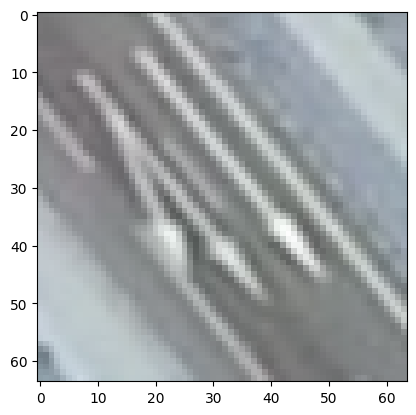

Y = 238.496, Yp = 27.885, error = 210.611


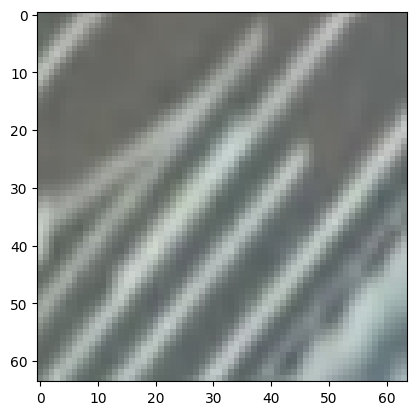

Y = 169.925, Yp = 71.026, error = 98.898


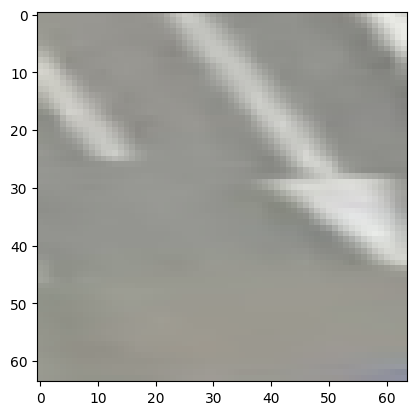

Y = 264.301, Yp = 220.313, error = 43.988


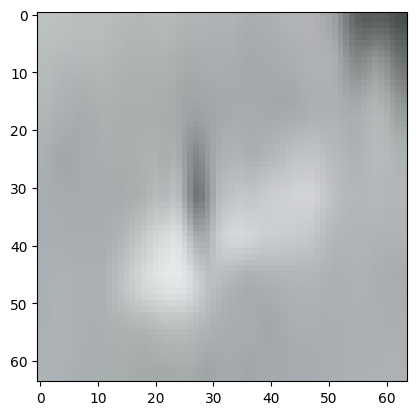

Y = 132.709, Yp = 178.452, error = 45.743


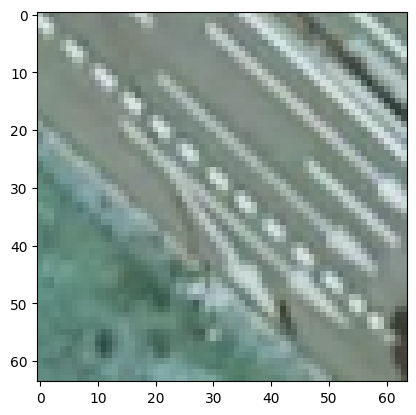

Y = 33.882, Yp = 66.446, error = 32.564


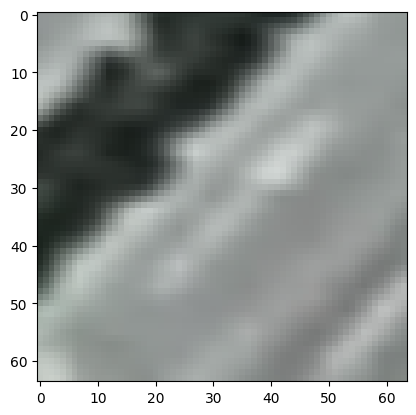

Y = 339.103, Yp = 301.902, error = 37.202


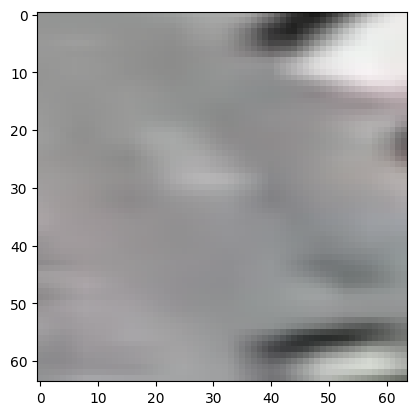

Y = 224.353, Yp = 177.039, error = 47.314


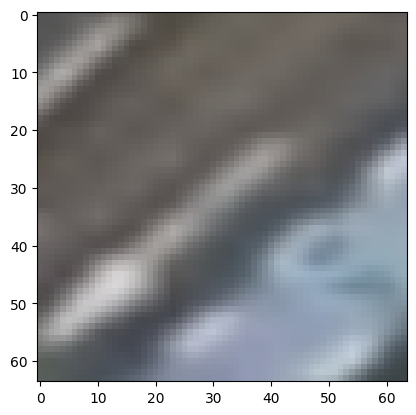

Y = 357.502, Yp = 144.232, error = 213.269


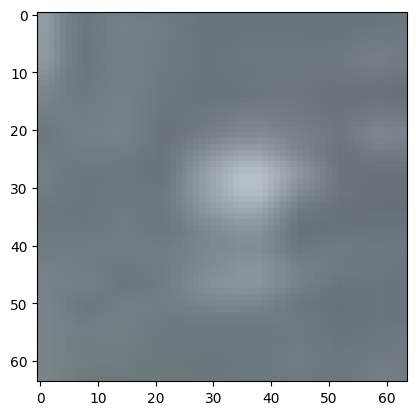

Y = 320.652, Yp = 272.089, error = 48.563


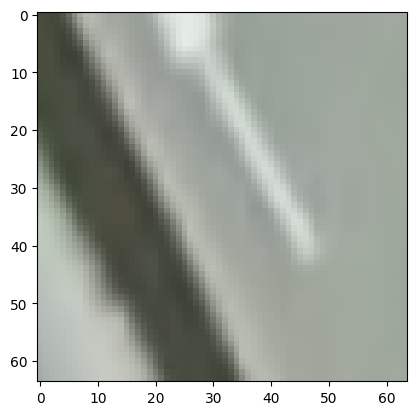

Y = 233.768, Yp = 168.925, error = 64.843


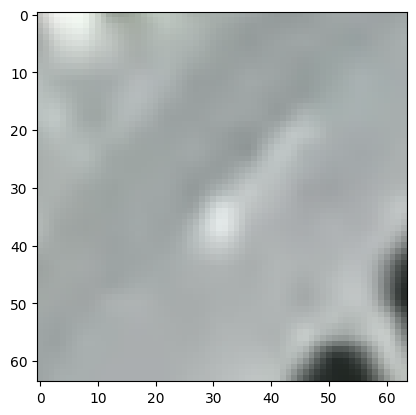

Y = 109.265, Yp = 294.146, error = 184.881


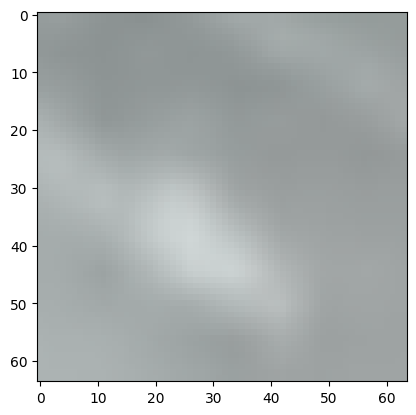

Y = 297.668, Yp = 270.764, error = 26.904


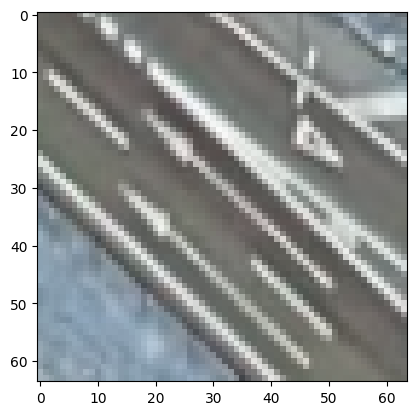

Y = 33.571, Yp = 110.796, error = 77.225


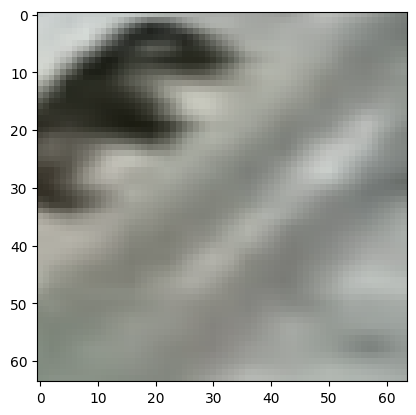

Y = 179.275, Yp = 320.332, error = 141.057


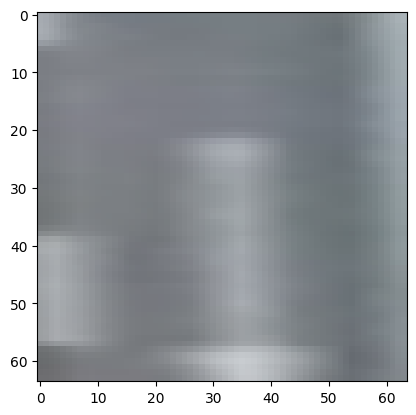

Y = 142.435, Yp = 196.967, error = 54.531


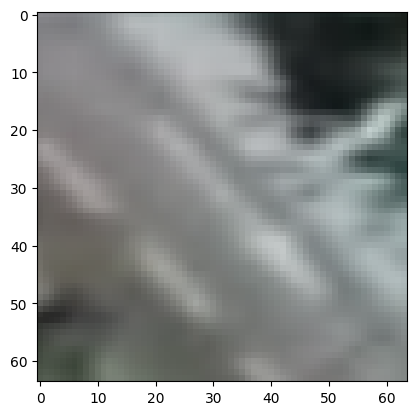

Y = 221.498, Yp = 193.512, error = 27.986


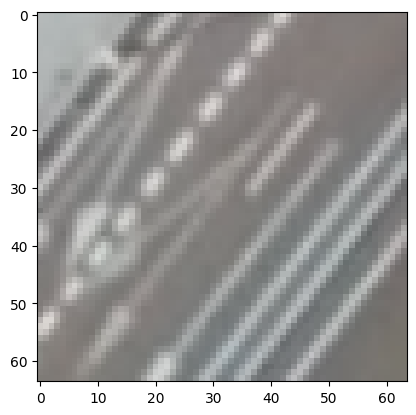

Y = 211.827, Yp = 45.047, error = 166.780


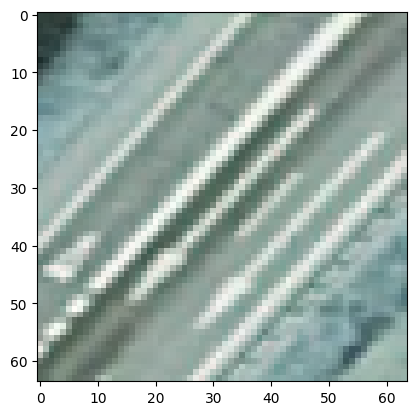

Y = 235.795, Yp = 126.570, error = 109.224


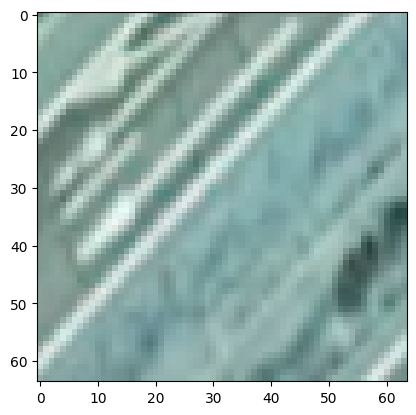

Y = 321.541, Yp = 273.475, error = 48.065


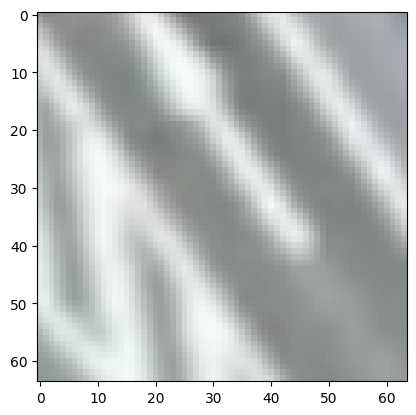

Y = 270.386, Yp = 244.987, error = 25.399


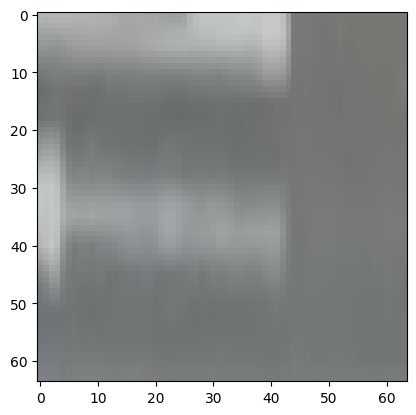

Y = 112.233, Yp = 251.012, error = 138.779


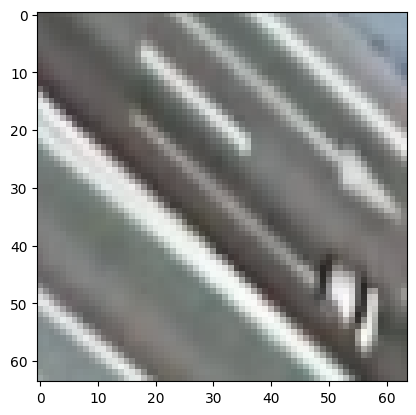

Y = 223.875, Yp = 141.737, error = 82.139


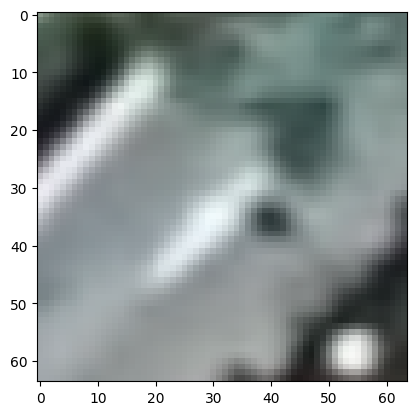

Y = 84.742, Yp = 216.445, error = 131.703


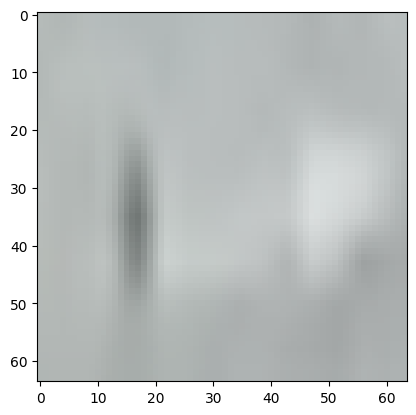

Y = 20.630, Yp = 177.384, error = 156.754


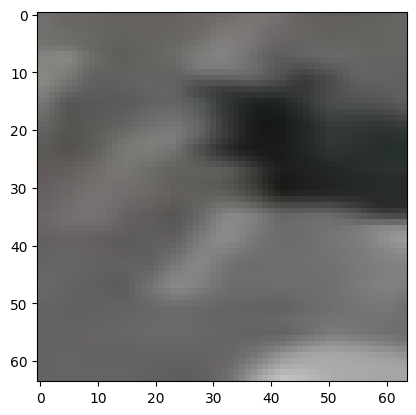

Y = 315.702, Yp = 278.730, error = 36.972


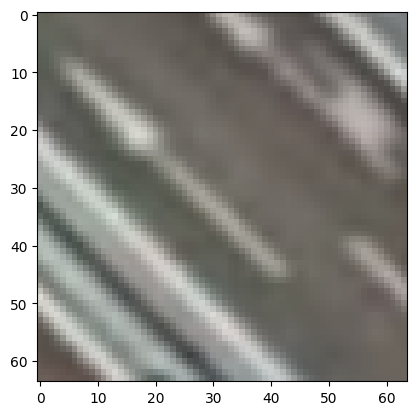

Y = 130.276, Yp = 199.845, error = 69.569


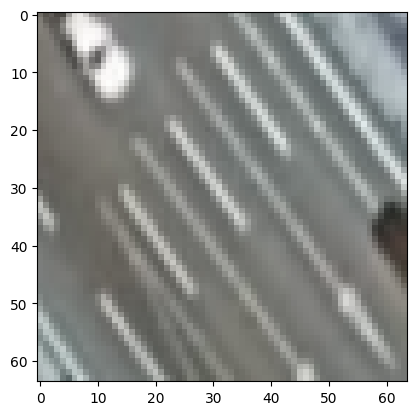

Y = 269.066, Yp = 215.817, error = 53.249


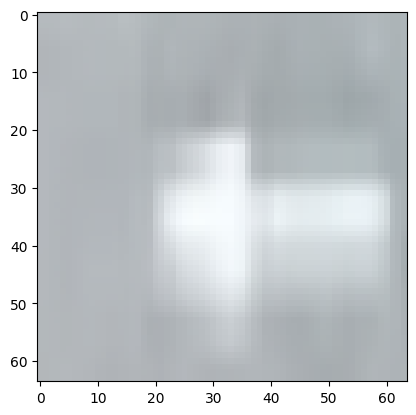

Y = 128.900, Yp = 84.072, error = 44.828


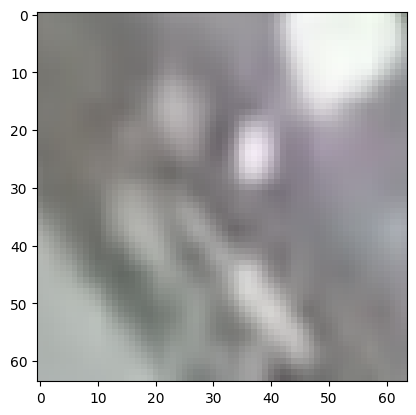

Y = 163.890, Yp = 321.578, error = 157.688


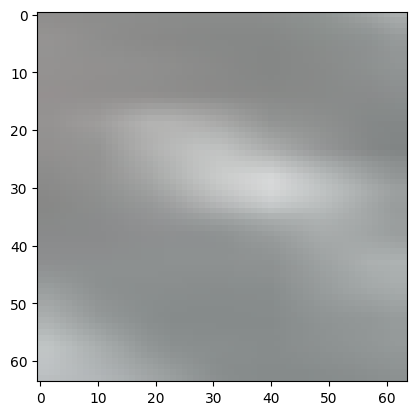

Y = 152.136, Yp = 185.065, error = 32.929


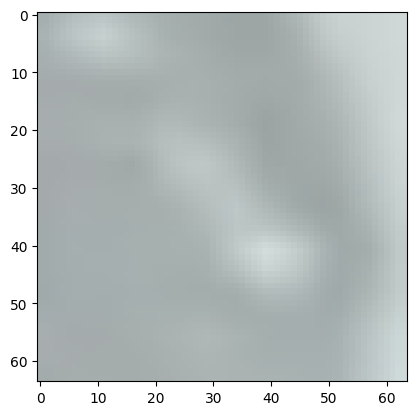

Y = 260.383, Yp = 185.581, error = 74.802


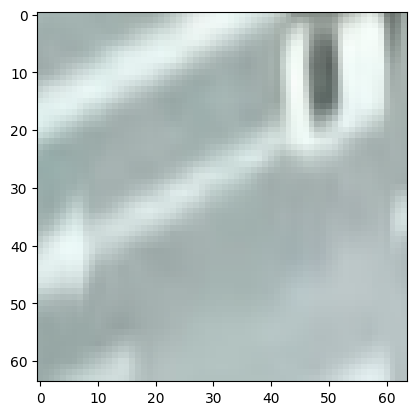

Y = 77.898, Yp = 113.727, error = 35.829


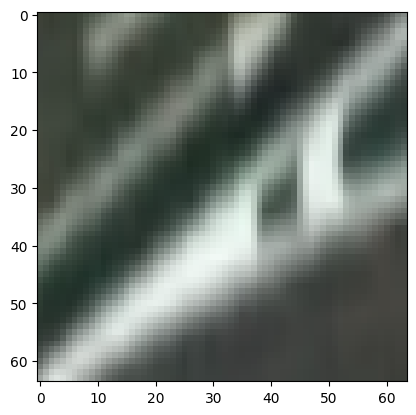

Y = 145.195, Yp = 113.980, error = 31.215


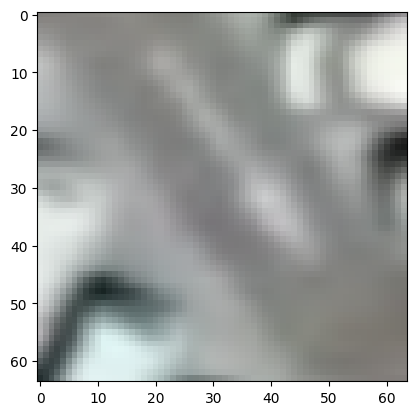

Y = 359.127, Yp = 223.418, error = 135.709


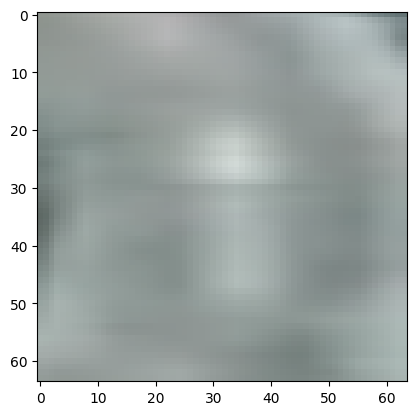

Y = 126.756, Yp = 205.175, error = 78.419


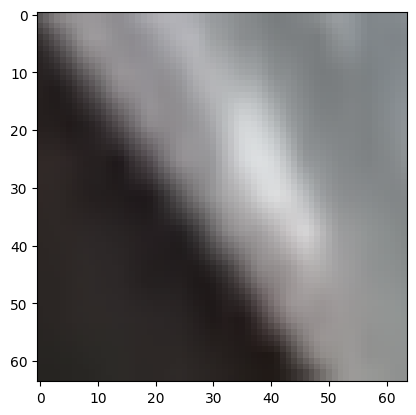

Y = 137.726, Yp = 214.572, error = 76.845


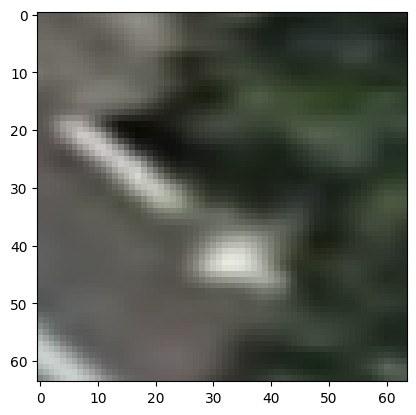

Y = 77.209, Yp = 102.778, error = 25.569


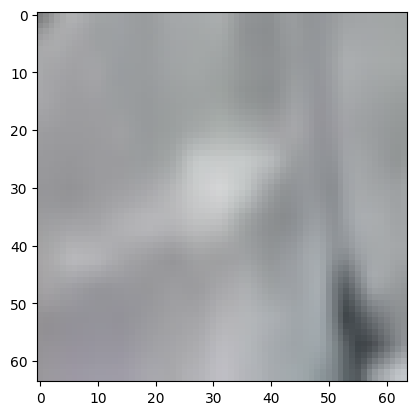

Y = 315.272, Yp = 219.438, error = 95.833


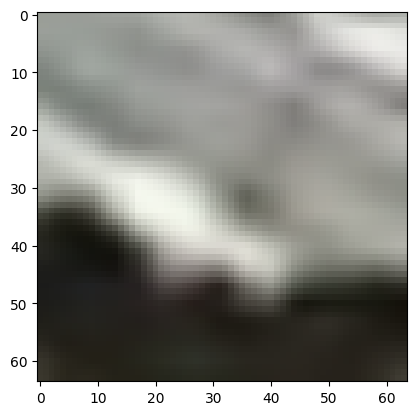

Y = 140.525, Yp = 309.373, error = 168.848


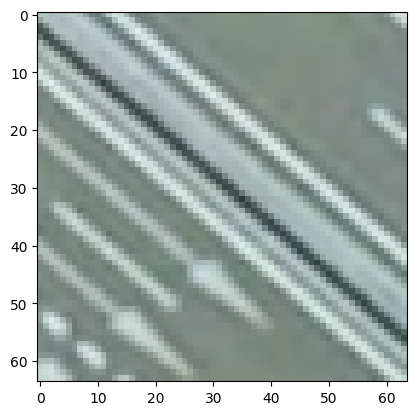

Y = 213.904, Yp = 59.458, error = 154.446


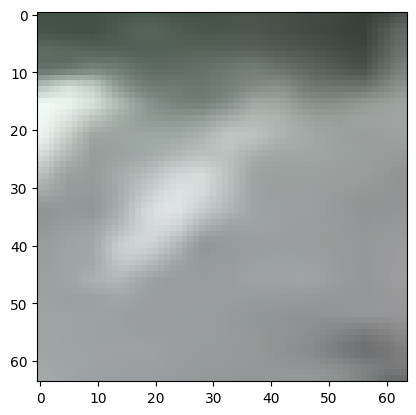

Y = 193.598, Yp = 59.952, error = 133.645


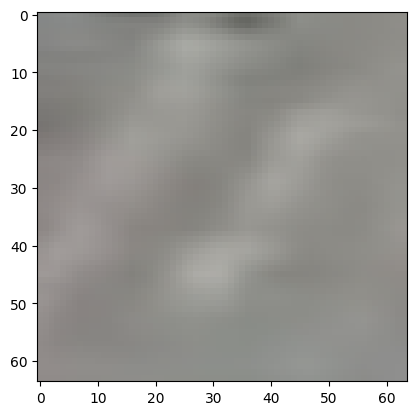

Y = 79.783, Yp = 48.545, error = 31.238


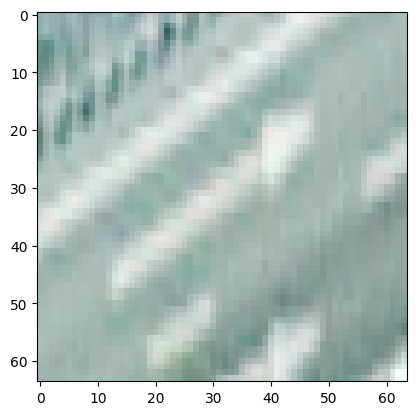

Y = 331.920, Yp = 262.096, error = 69.824


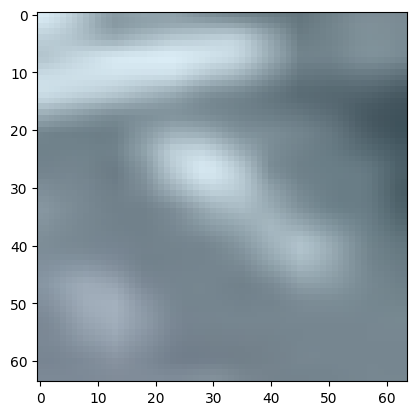

Y = 110.620, Yp = 255.272, error = 144.652


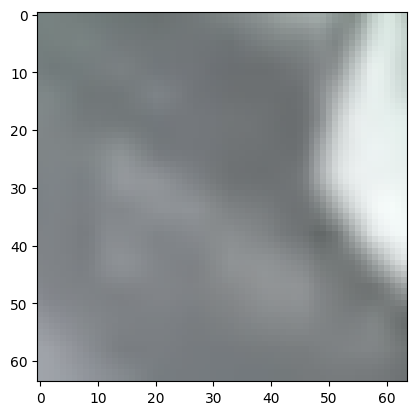

Y = 108.087, Yp = 176.294, error = 68.207


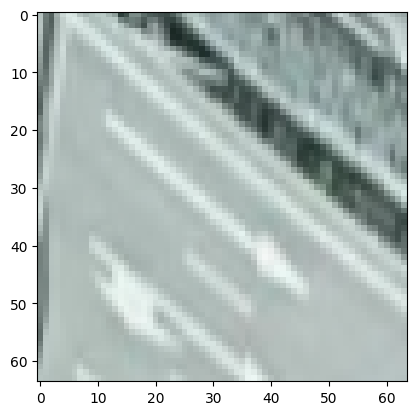

Y = 346.958, Yp = 290.407, error = 56.551


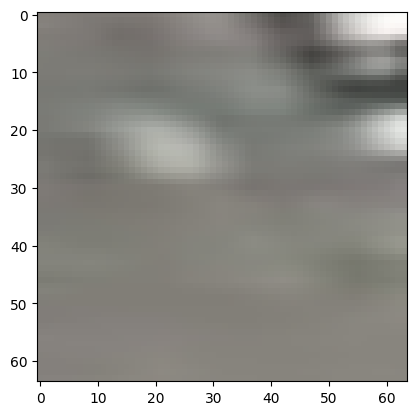

Y = 230.262, Yp = 202.589, error = 27.673


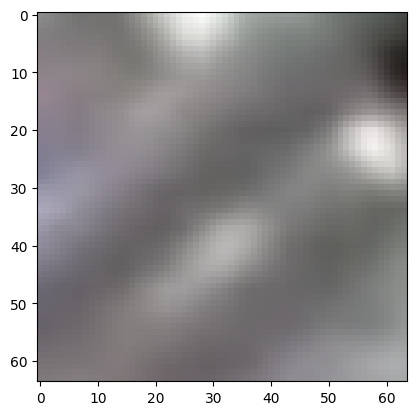

Y = 322.696, Yp = 295.448, error = 27.248


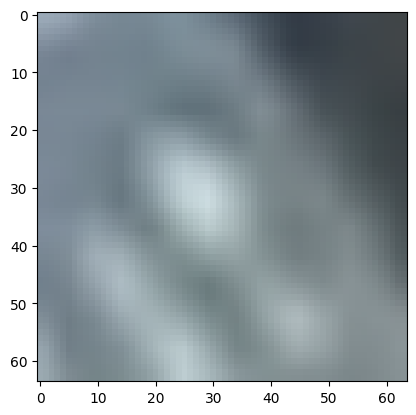

Y = 206.752, Yp = 110.078, error = 96.674


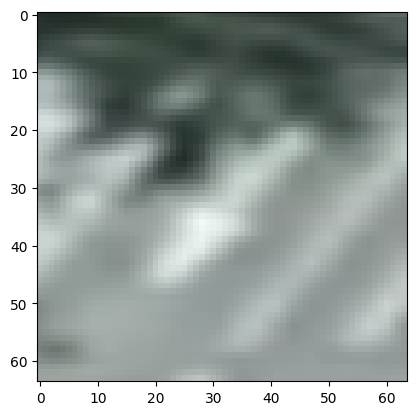

Y = 127.323, Yp = 274.139, error = 146.816


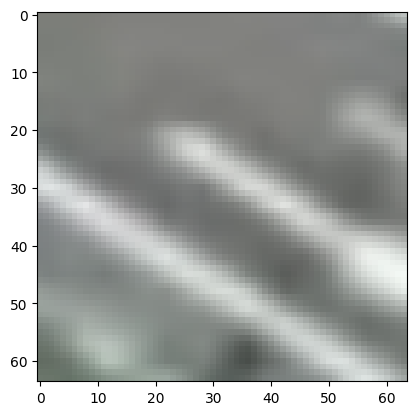

Y = 351.209, Yp = 318.399, error = 32.810


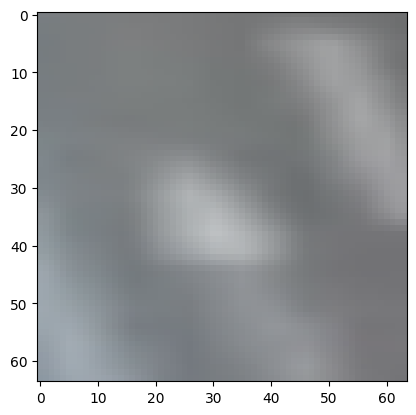

Y = 178.600, Yp = 105.104, error = 73.496


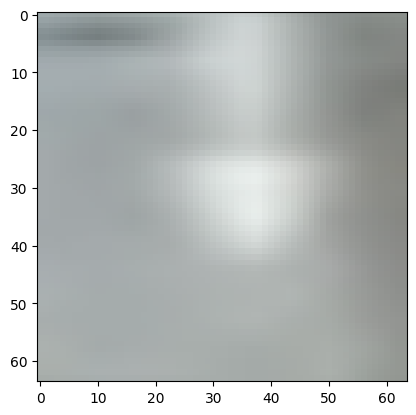

Y = 257.594, Yp = 64.347, error = 193.247


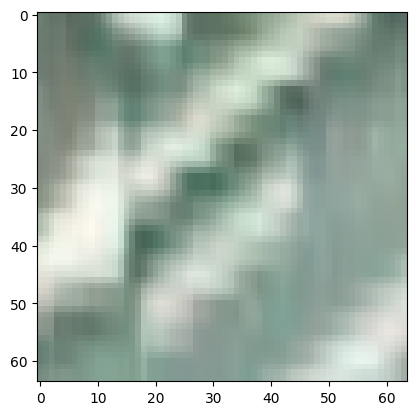

Y = 320.793, Yp = 294.820, error = 25.973


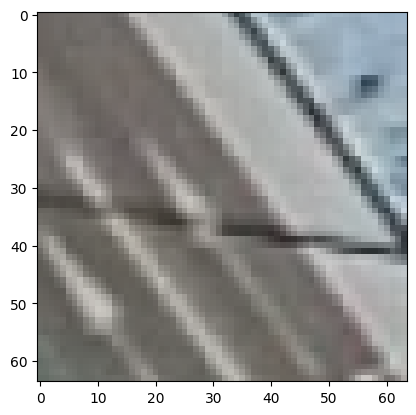

Y = 349.095, Yp = 248.929, error = 100.166


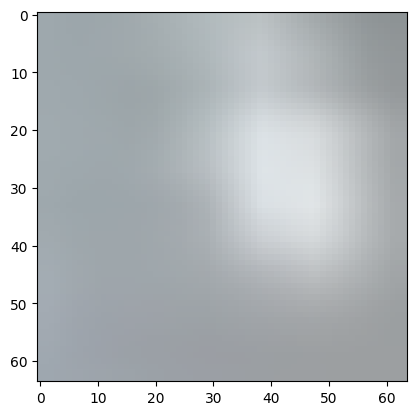

Y = 27.301, Yp = 88.408, error = 61.107


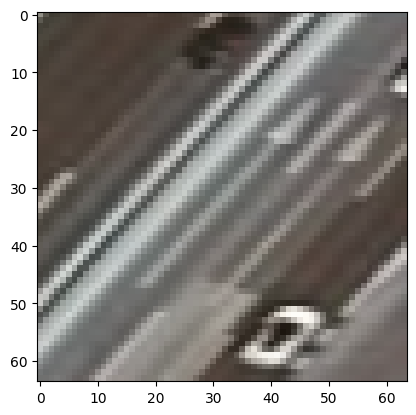

Y = 25.973, Yp = 117.640, error = 91.667


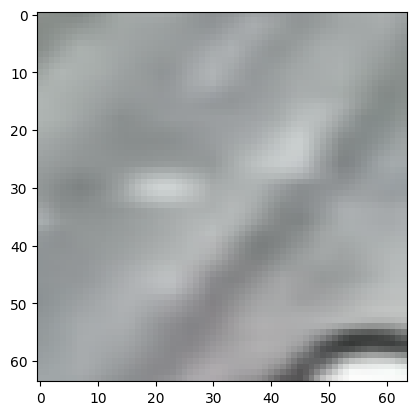

Y = 114.262, Yp = 182.525, error = 68.263


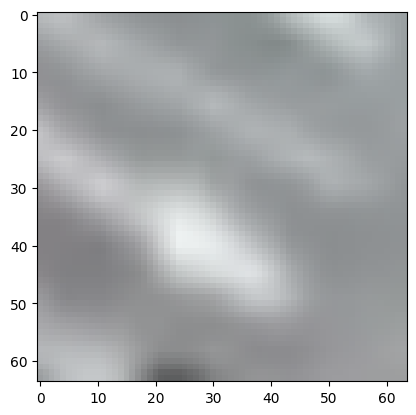

Y = 183.827, Yp = 99.207, error = 84.620


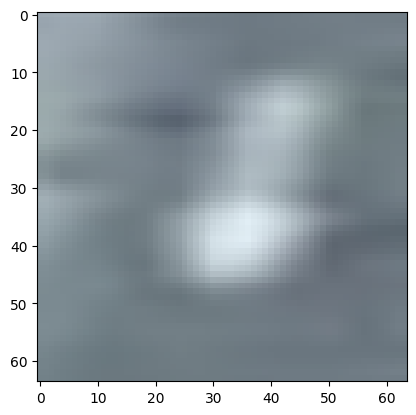

Y = 199.179, Yp = 102.539, error = 96.640


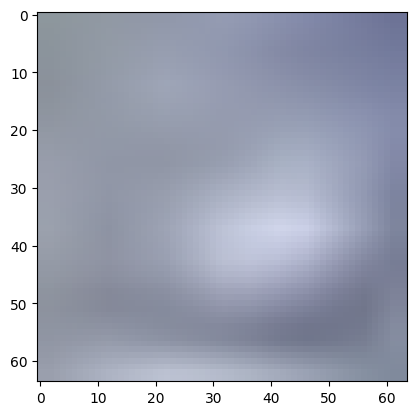

Y = 239.705, Yp = 73.467, error = 166.238


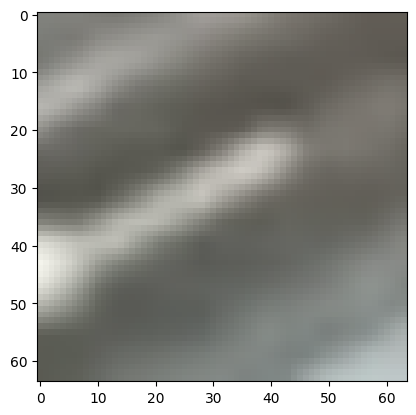

Y = 52.714, Yp = 150.577, error = 97.863


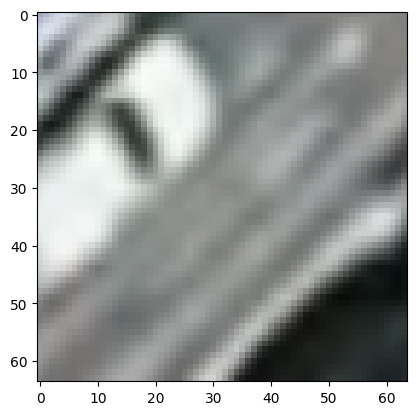

Y = 328.713, Yp = 284.130, error = 44.583


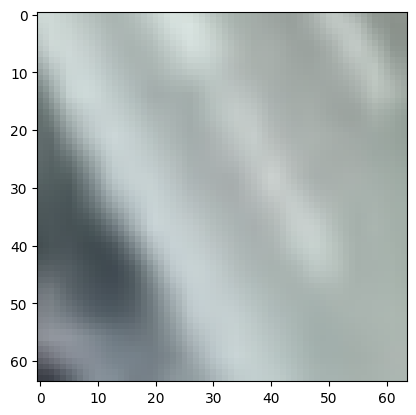

Y = 168.540, Yp = 254.486, error = 85.946


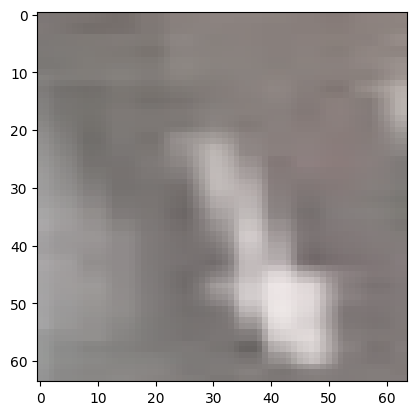

Y = 313.705, Yp = 288.268, error = 25.436


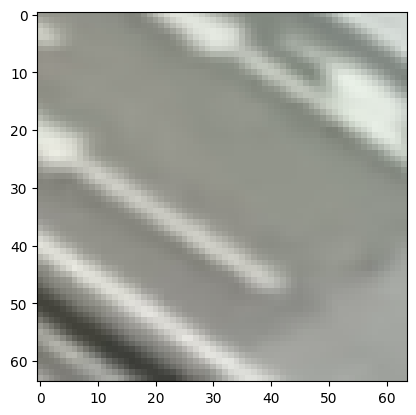

Y = 1.149, Yp = 345.559, error = 344.410


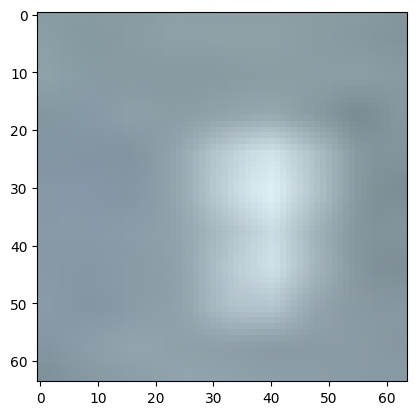

Y = 1.469, Yp = 49.836, error = 48.367


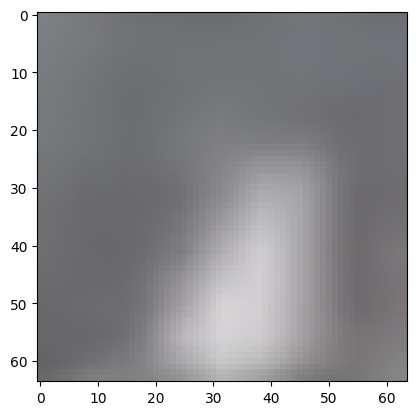

Y = 123.758, Yp = 234.991, error = 111.233


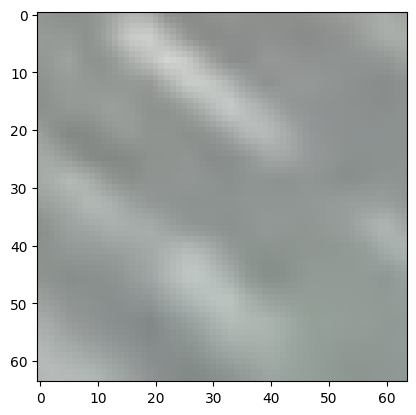

Y = 131.293, Yp = 208.910, error = 77.616


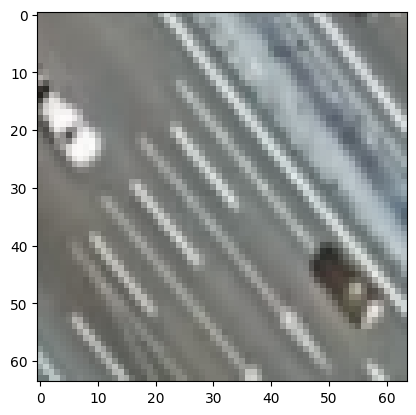

Y = 32.776, Yp = 162.637, error = 129.860


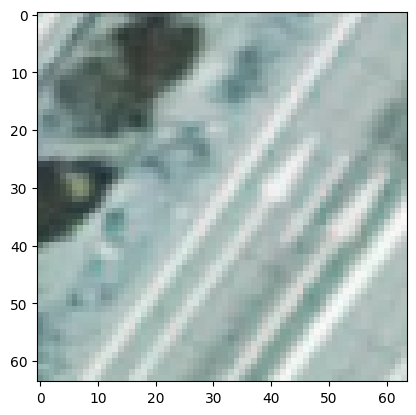

Y = 359.823, Yp = 265.366, error = 94.457


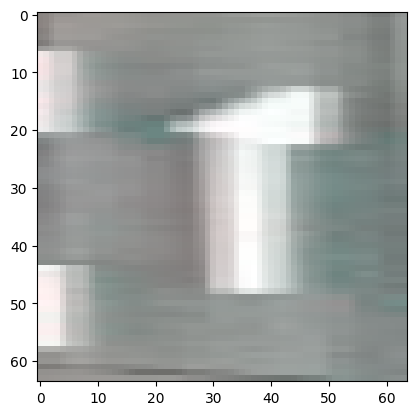

Y = 136.698, Yp = 174.023, error = 37.325


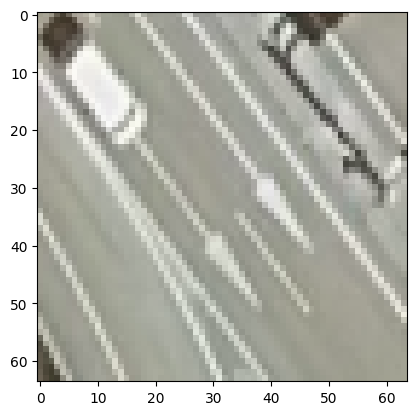

Y = 354.318, Yp = 327.320, error = 26.998


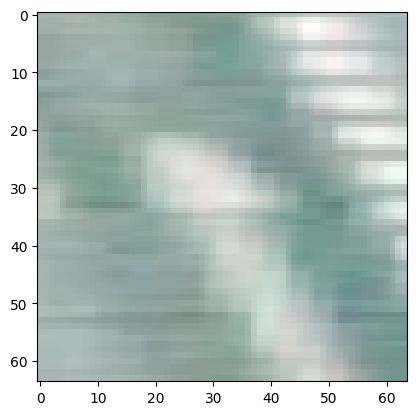

Y = 28.128, Yp = 202.527, error = 174.399


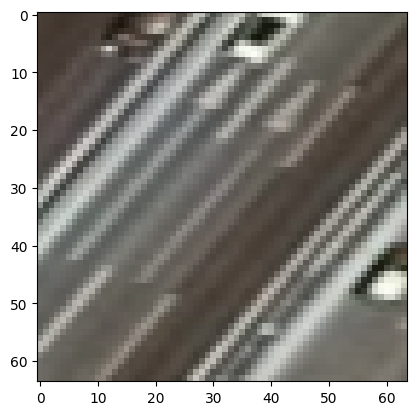

Y = 113.503, Yp = 140.143, error = 26.640


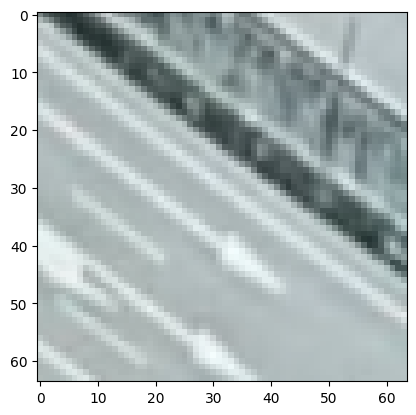

Y = 27.223, Yp = 177.254, error = 150.030


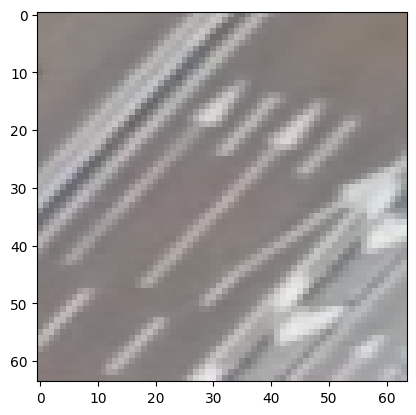

Y = 288.346, Yp = 236.750, error = 51.596


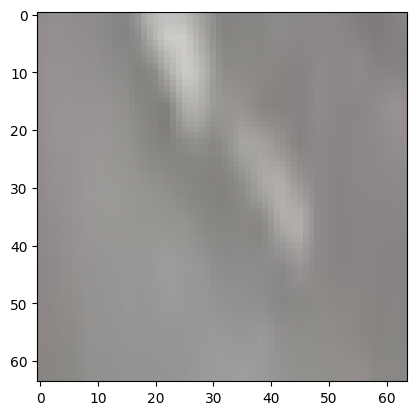

Y = 122.196, Yp = 155.536, error = 33.340


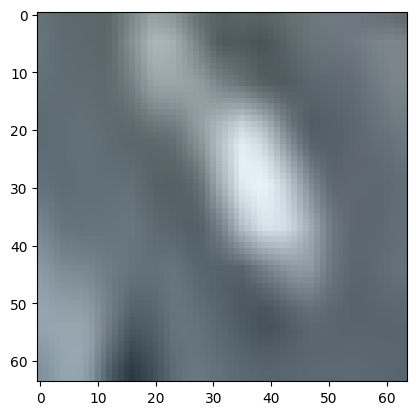

Y = 120.009, Yp = 176.401, error = 56.391


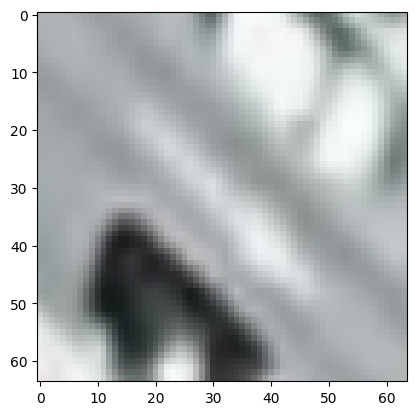

Y = 312.817, Yp = 186.625, error = 126.192


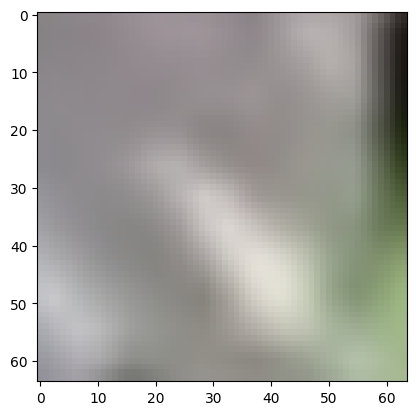

Y = 280.651, Yp = 316.188, error = 35.537


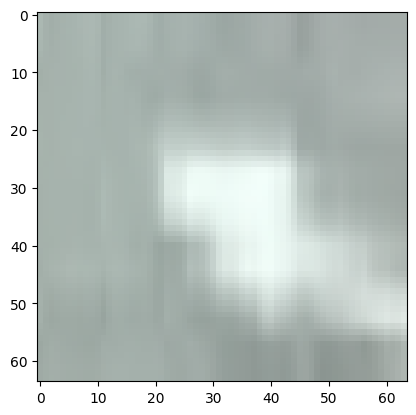

Y = 312.758, Yp = 156.479, error = 156.279


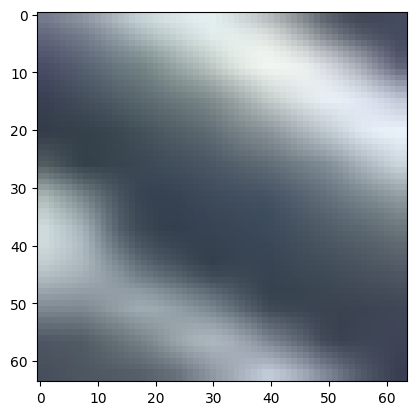

Y = 79.824, Yp = 115.310, error = 35.486


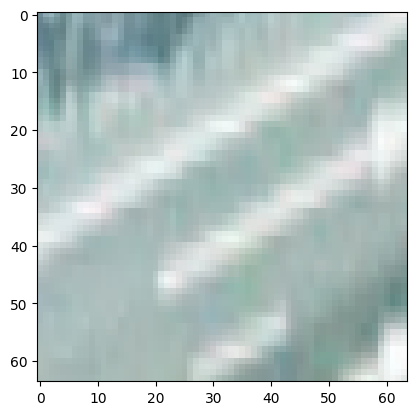

Y = 289.234, Yp = 208.998, error = 80.236


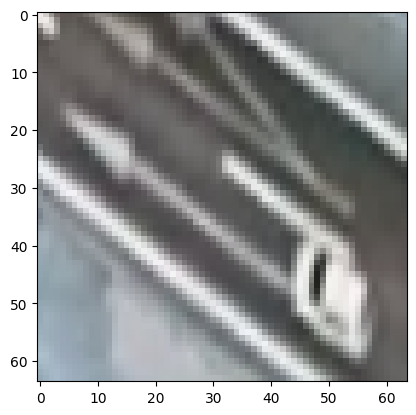

Y = 13.623, Yp = 114.842, error = 101.219


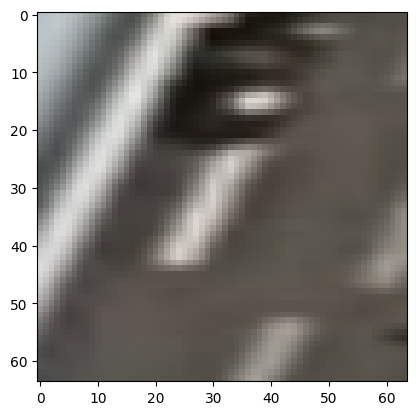

Y = 265.388, Yp = 82.386, error = 183.001


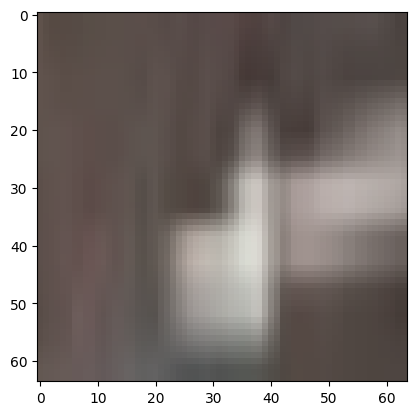

Y = 350.985, Yp = 213.548, error = 137.437


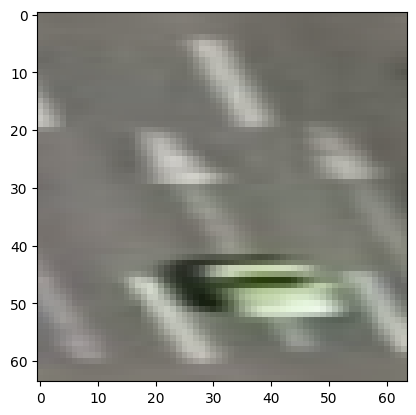

Y = 179.585, Yp = 111.757, error = 67.828


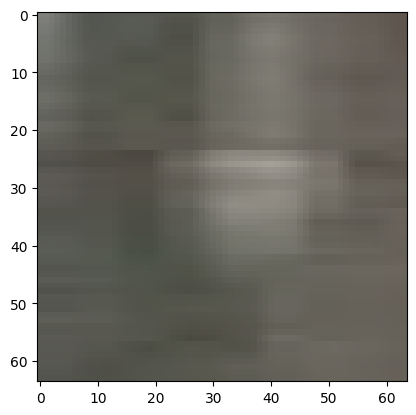

Y = 302.125, Yp = 276.237, error = 25.888


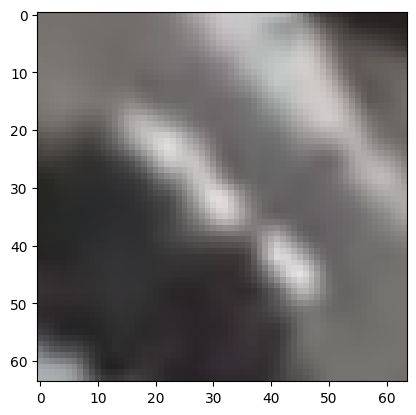

Y = 111.736, Yp = 210.930, error = 99.193


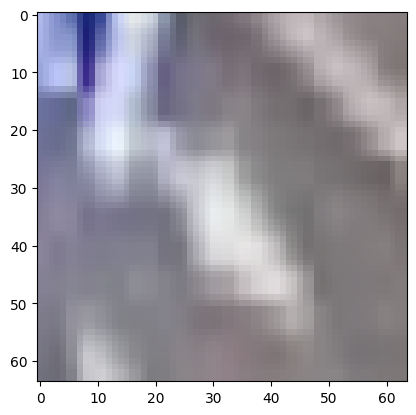

Y = 327.253, Yp = 295.978, error = 31.275


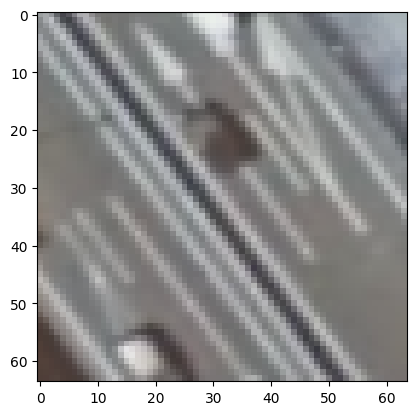

Y = 126.757, Yp = 262.006, error = 135.248


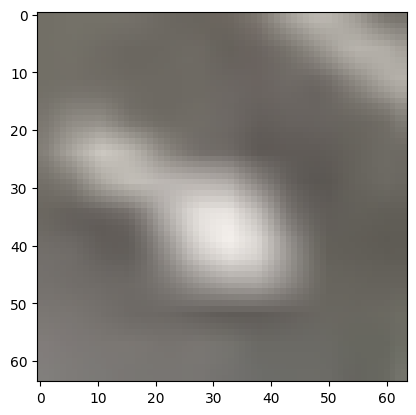

Y = 340.538, Yp = 288.537, error = 52.001


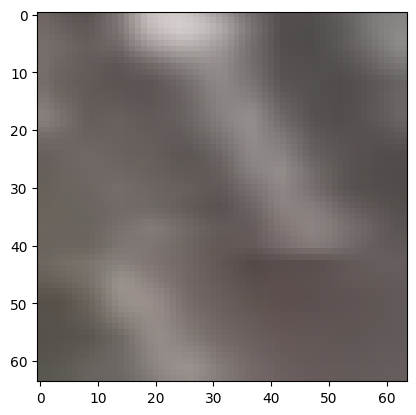

Y = 45.985, Yp = 196.481, error = 150.496


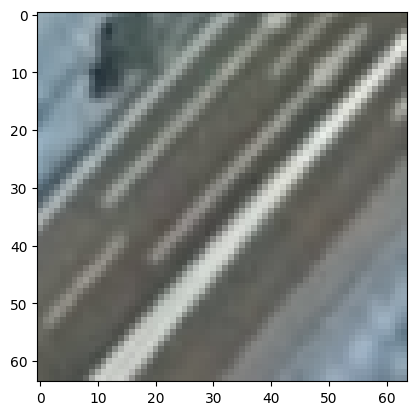

Y = 323.846, Yp = 188.374, error = 135.473


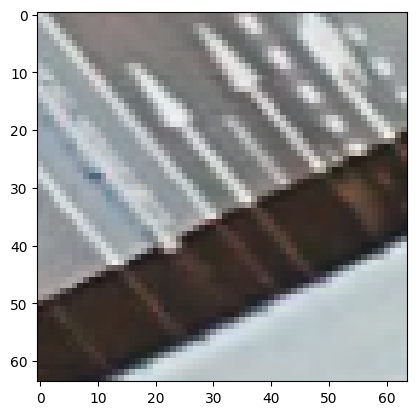

Y = 121.836, Yp = 281.378, error = 159.543


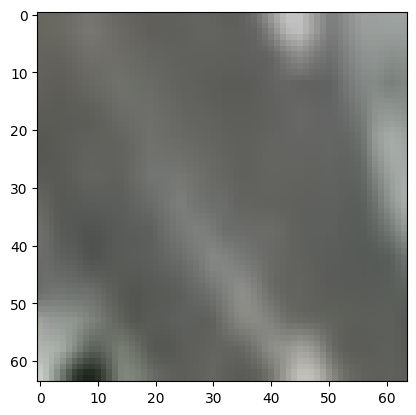

Y = 107.070, Yp = 180.313, error = 73.243


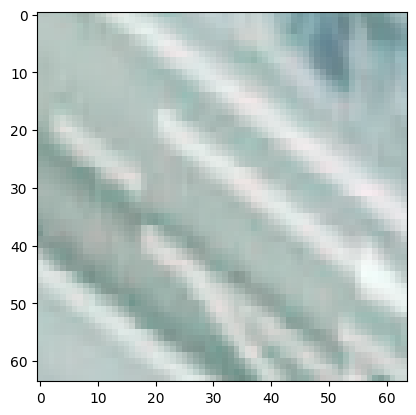

Y = 209.544, Yp = 154.194, error = 55.349


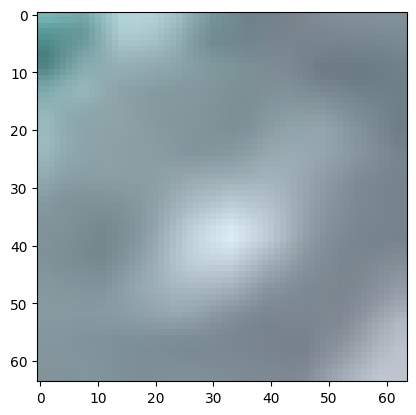

Y = 78.082, Yp = 46.389, error = 31.693


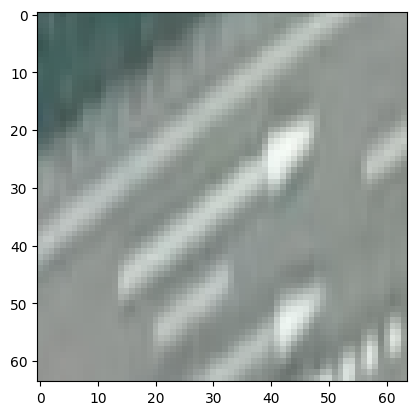

Y = 90.700, Yp = 218.559, error = 127.859


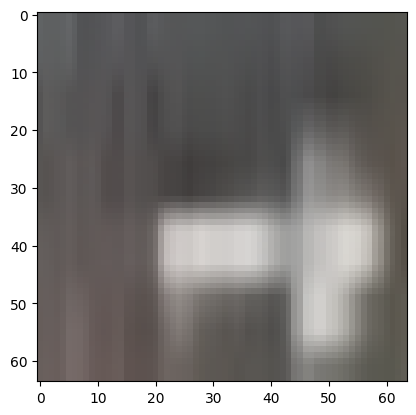

In [10]:
Y_predicted = model.predict(X_test)
errors = []
for X, Y, Yp in zip(X_test, Y_test, Y_predicted):
    #show the pictures of only the ones that are wrong
    if abs(360*Yp[0]-360*Y) > 25:
        errors.append((Y*360,Yp[0]*360,X))
        continue
    print(f"Y = {360*Y:.3f}, Yp = {360*Yp[0]:.3f}, error = {abs(360*Yp[0]-360*Y):.3f}")
print("DEVIATED ANGLES BY MORE THAN 25 DEGREES")
for Y,Yp,X in errors:
    print(f"Y = {Y:.3f}, Yp = {Yp:.3f}, error = {abs(Yp-Y):.3f}")
    plt.imshow(X)
    plt.show()

In [11]:
model.save("./models/14-03-23-18:37.h5")

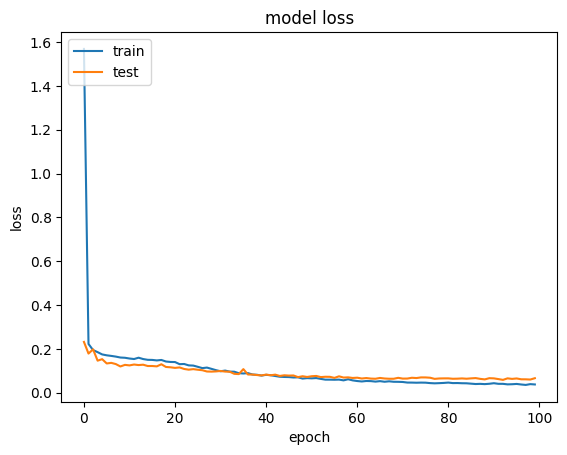

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [13]:
model.evaluate(X_test, Y_test)

21/21 [==============================] - 1s 29ms/step - loss: 0.0717 - mean_absolute_error: 0.0717 - mean_squared_error: 0.0244


[0.07169314473867416, 0.07169314473867416, 0.02436893619596958]